In [198]:
from PIL import Image
from skimage.feature import local_binary_pattern, hog, greycomatrix, greycoprops
from skimage.filters import gabor_kernel
from scipy import ndimage, linalg
from tqdm import tqdm
import numpy as np
import glob
from torch.nn.functional import logsigmoid
import torch.nn as nn
import torch
import random
import heapq
import matplotlib.pyplot as plt
import math

In [126]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [127]:
class LocalBinaryPatterns:
    def __init__(self, P=8, R=2):
        self.P = P
        self.R = R
        self.bins = np.arange(0, 60) - 0.5
        self.bins[-1] = 255.5
    def describe(self, image, eps=1e-7):
        lbp = local_binary_pattern(image, self.P, self.R)
        (hist, _) = np.histogram(lbp.ravel(), bins=self.bins)
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

class HOG:
    def __init__(self, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1)):
        self.ori = orientations
        self.ppc = pixels_per_cell
        self.cpb = cells_per_block
    def describe(self, image):        
        return hog(image,
                   orientations=self.ori,
                   pixels_per_cell=self.ppc,
                   cells_per_block=self.cpb)

class Gabor:
    def __init__(self, theta_range=8, sigmas=(1,3), frequencies=(0.05, 0.25)):
        kernels = []
        for theta in range(theta_range):
            theta = theta / 4. * np.pi
            for sigma in sigmas:
                for frequency in frequencies:
                    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                                  sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)
        self.kernels = kernels
    
    def describe(self, image):
        feats = np.zeros((len(self.kernels) * 2,), dtype=np.double)
        for k, kernel in enumerate(self.kernels):
            filtered = ndimage.convolve(image, kernel, mode='wrap')
            feats[2*k] = filtered.mean()
            feats[2*k+1] = filtered.var()
        return feats
    
class Haralick:
    def __init__(self, distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
        self.distances = distances
        self.angles = angles
        self.n = len(distances) * len(angles)
        self.props = ('contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation')
    def describe(self, image):
        glcm = greycomatrix(image, distances=self.distances, angles=self.angles,
                            levels=256, symmetric=True, normed=True)
        feats = np.empty((self.n * 6,), dtype=np.double)
        for i, prop in enumerate(self.props):
            feats[i * self.n : (i+1) * self.n] = greycoprops(glcm, prop).ravel()
        return feats

In [129]:
def extract_features(img_folder_path, crop_box=None):
    _lbp = LocalBinaryPatterns()
    _hog = HOG()
    _gabor = Gabor()
    _haralick = Haralick()
    featmat = None
    img_paths = glob.glob(img_folder_path + '*.jpg')
    img_paths.sort()
    print(img_folder_path, ': %d images found' % len(img_paths))
    for i, imgpath in tqdm(enumerate(img_paths)):
        img = Image.open(imgpath)
        if crop_box:
            img = img.crop(crop_box)
        img_gray = img.convert('L')
        lbp_feat = _lbp.describe(img_gray)
        hog_feat = _hog.describe(img)
        gab_feat = _gabor.describe(img_gray)
        har_feat = _haralick.describe(np.asarray(img_gray).copy())
        feat_list = (
            lbp_feat,
            hog_feat,
            gab_feat,
            har_feat,
        )
        feat_size = sum(len(x) for x in feat_list)
        if featmat is None:
            featmat = np.empty((len(img_paths), feat_size))
            print("featmat.shape = ", featmat.shape)
        offset = 0
        for feat in feat_list:
            featmat[i][offset:offset+len(feat)] = feat
            offset += len(feat)
    return featmat, img_paths

In [130]:
featmat, paths = extract_features('./FaceMask166/', crop_box=(40,0,215,105))

0it [00:00, ?it/s]

./FaceMask166/ : 996 images found


1it [00:00,  4.71it/s]

featmat.shape =  (996, 675)


996it [03:21,  4.95it/s]


In [131]:
np.save('features_crop(40,0,215,105)_lbp_hog_gabor_haralick.npy', featmat)

In [132]:
featmat = np.load('./features_crop(40,0,215,105)_lbp_hog_gabor_haralick.npy')
featmat = (featmat - featmat.mean(0)) / featmat.std(0)
featmat.shape

(996, 675)

In [133]:
paths = glob.glob('./FaceMask166/*.jpg')
paths.sort()

In [248]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        assert len(layer_sizes) >= 2
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
    def forward(self, X):
        n = len(self.layers)
        for i in range(n-1):
            X = torch.relu(self.layers[i](X))
        X = self.layers[-1](X)
        return X

In [295]:
def get_training_triplet_samples(m, k=3):
    triplets = []
    for i in range(m):
        for k1 in range(k):
            for k2 in range(k1+1, k):
                for j in range(m):
                    if i == j:
                        continue
                    for k3 in range(k):
                        triplets.append((i*6+k1, i*6+k2, j*6+k3))
                        triplets.append((i*6+k2, i*6+k1, j*6+k3))
    random.shuffle(triplets)
    return triplets

In [296]:
def triplet_margin_loss_forward(anchor, pos, neg, margin):
    dist2_pos = torch.sum((anchor - pos)**2, dim=1)
    dist2_neg = torch.sum((anchor - neg)**2, dim=1)
    delta = dist2_pos - dist2_neg
    loss = torch.mean(torch.clamp(delta + margin, min=0.))
    correctly_ranked = delta < 0.
    return loss, correctly_ranked

def triplet_crossentropy_loss_forward(anchor, pos, neg):
    dist2_pos = torch.sum((anchor - pos)**2, dim=1)
    dist2_neg = torch.sum((anchor - neg)**2, dim=1)
    delta = dist2_neg - dist2_pos
    loss = -torch.mean(logsigmoid(delta))
    correctly_ranked = delta > 0.
    return loss, correctly_ranked

In [302]:
class Experiment:
    
    def __init__(self, featmat, m, batch_size, train_k=3):
        
        triplets = get_training_triplet_samples(m, k=train_k)
        n_batches = len(triplets) // batch_size + (len(triplets) % batch_size > 0)
        batches = [[] for _ in range(n_batches)]
        for i, t in enumerate(triplets):
            batches[i % n_batches].append(t)
        for i, batch in enumerate(batches):
            batches[i] = torch.LongTensor(batch)
        self.batches = batches
        
        embed = nn.Embedding(*featmat.shape)
        embed.weight.data.copy_(torch.from_numpy(featmat))
        embed.weight.requires_grad = False
        embed = embed.to(DEVICE)
        self.embed = embed
        self.embed_dim = featmat.shape[1]
        
        self.train_indexes = torch.LongTensor([i for i in range(m * 6) if (i % 6) < train_k]).to(DEVICE)
        self.train_labels = [i//6 for i in range(m * 6) if (i % 6) < train_k]
        self.val_indexes = torch.LongTensor([i for i in range(m * 6) if (i % 6) == train_k]).to(DEVICE)
        self.val_labels = [i//6 for i in range(m * 6) if (i % 6) == train_k]
        self.test_indexes = torch.LongTensor([i for i in range(m * 6) if (i % 6) > train_k]).to(DEVICE)
        self.test_labels = [i//6 for i in range(m * 6) if (i % 6) > train_k]
        
    def sanity_check(self, featmat):
        
        delta = self.embed.weight.cpu().numpy() - featmat
        assert max(abs(delta.max()), abs(delta.min())) < 1e-6
        
        train_indexes_set = set(i.item() for i in self.train_indexes)
        val_indexes_set = set(i.item() for i in self.val_indexes)
        test_indexes_set = set(i.item() for i in self.test_indexes)
        
        assert len(train_indexes_set) == len(self.train_indexes)
        assert len(val_indexes_set) == len(self.val_indexes)
        assert len(test_indexes_set) == len(self.test_indexes)
        
        assert len(train_indexes_set & val_indexes_set) == 0
        assert len(train_indexes_set & test_indexes_set) == 0
        assert len(val_indexes_set & test_indexes_set) == 0
        
        for batch in self.batches:
            for i in batch.view(-1):
                try:
                    assert i.item() in train_indexes_set
                except AssertionError:
                    print('i.item() = ', i.item())
                    print('train_indexes_set = ', train_indexes_set)
                    raise                
        
    def train_mlp(self, featmat, hidden_layers, max_iter, lr=1e-3, verbose=False, print_every=10):
        
        layer_sizes = (self.embed_dim, *hidden_layers)
        mlp = MLP(layer_sizes)
        mlp = mlp.to(DEVICE)
        mlp.train()
        optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
        self.embed.weight.requires_grad = False
        
        loss_ema = None
        acc_ema = None
        i = 0
        while True:
            for batch in self.batches:
                batch = batch.to(DEVICE)
                X = mlp(self.embed(batch.T))
                optimizer.zero_grad()
                loss, correctly_ranked = triplet_crossentropy_loss_forward(X[0], X[1], X[2])
                loss.backward()
                optimizer.step()

                if loss_ema is None:
                    loss_ema = loss.item()
                    acc_ema = torch.sum(correctly_ranked) / X.size(1)
                else:
                    loss_ema = loss_ema * 0.9 + loss.item() * 0.1
                    acc_ema = acc_ema * 0.9 + (torch.sum(correctly_ranked).item() / X.size(1)) * 0.1

                i += 1
                if verbose:
                    if i == 1 or i == max_iter or (i % print_every) == 0:
                        print("iter = %d, loss_ema = %.8f, acc_ema = %.8f" % (i, loss_ema, acc_ema))
                if i >= max_iter:
                    break
            if i >= max_iter:
                    break
        
        return mlp
    
    def _evaluate_mlp(self, eval_indexes, eval_labels, mlp, topk=5):
        
        mlp.eval()
        with torch.set_grad_enabled(False):
            X_train = mlp(self.embed(self.train_indexes))
            X_eval = mlp(self.embed(eval_indexes))

        correct = 0
        for i, elabel in enumerate(eval_labels):
            h = []
            for j, tlabel in enumerate(self.train_labels):
                dist2 = ((X_eval[i] - X_train[j])**2).sum().item()
                p = (-dist2, tlabel)
                if len(h) < topk:
                    heapq.heappush(h, p)
                else:
                    heapq.heappushpop(h, p)
            h.sort(reverse=True)
            counts = dict()
            maxc = 0
            for _, l in h:
                counts[l] = counts.get(l,0) + 1
                if counts[l] > maxc:
                    maxc = counts[l]
                    predl = l
            if predl == elabel:
                correct += 1
        return correct / len(eval_labels)
    
    def evaluate_mlp_train(self, mlp, topk=5):
        return self._evaluate_mlp(self.train_indexes, self.train_labels, mlp, topk)
    
    def evaluate_mlp_validation(self, mlp, topk=5):
        return self._evaluate_mlp(self.val_indexes, self.val_labels, mlp, topk)
    
    def evaluate_mlp_test(self, mlp, topk=5):
        return self._evaluate_mlp(self.test_indexes, self.test_labels, mlp, topk)
    
    def visualize_rankings(self, eval_indexes, eval_labels, img_paths, mlp, n_samples, topk=5, figsize=(20,10)):
        
        _idxs = random.sample(range(len(eval_indexes)), n_samples)
        eval_indexes = [eval_indexes[i] for i in _idxs]
        eval_labels = [eval_labels[i] for i in _idxs]
        
        mlp.eval()
        with torch.set_grad_enabled(False):
            X_train = mlp(self.embed(self.train_indexes))
            X_eval = mlp(self.embed(torch.LongTensor(eval_indexes).to(DEVICE)))
            
        nrows = n_samples
        ncols = 1 + topk
        plt.figure(1, figsize)
            
        for i, elabel in enumerate(eval_labels):
            h = []
            for j, tlabel in enumerate(self.train_labels):
                dist2 = ((X_eval[i] - X_train[j])**2).sum().item()
                p = (-dist2, self.train_indexes[j], tlabel)
                if len(h) < topk:
                    heapq.heappush(h, p)
                else:
                    heapq.heappushpop(h, p)
            h.sort(reverse=True)
            
            ax = plt.subplot(nrows, ncols, 1 + ncols * i)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            img = Image.open(img_paths[eval_indexes[i]])
            ax.set_title('query: idx = %d, label = %d' % (eval_indexes[i], eval_labels[i]))
            ax.imshow(img, interpolation="nearest")
            
            for k in range(topk):
                ax = plt.subplot(nrows, ncols, 1 + ncols * i + 1 + k)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                img = Image.open(img_paths[h[k][1]])
                ax.set_title('idx = %d, label = %d,\ndist=%.8f' % (h[k][1], h[k][2], -h[k][0]))
                ax.imshow(img, interpolation="nearest")
                
        plt.show()
        
        
        

In [312]:
exp = Experiment(featmat, m=166, batch_size=50000, train_k=5)

In [313]:
len(exp.batches[0]) * len(exp.batches)

2739000

In [314]:
exp.sanity_check(featmat)

In [315]:
mlp = exp.train_mlp(featmat, [100, 10], 10000, lr=0.7e-3, verbose=True, print_every=400)

iter = 1, loss_ema = 0.59926665, acc_ema = 0.00000000
iter = 400, loss_ema = 0.00016539, acc_ema = 0.99999976
iter = 800, loss_ema = 0.00003532, acc_ema = 0.99999976
iter = 1200, loss_ema = 0.00001503, acc_ema = 0.99999976
iter = 1600, loss_ema = 0.00000780, acc_ema = 0.99999976
iter = 2000, loss_ema = 0.00000469, acc_ema = 0.99999976
iter = 2400, loss_ema = 0.00000296, acc_ema = 0.99999976
iter = 2800, loss_ema = 0.00000204, acc_ema = 0.99999976
iter = 3200, loss_ema = 0.00000143, acc_ema = 0.99999976
iter = 3600, loss_ema = 0.00000102, acc_ema = 0.99999976
iter = 4000, loss_ema = 0.00000076, acc_ema = 0.99999976
iter = 4400, loss_ema = 0.00000057, acc_ema = 0.99999976
iter = 4800, loss_ema = 0.00000043, acc_ema = 0.99999976
iter = 5200, loss_ema = 0.00000032, acc_ema = 0.99999976
iter = 5600, loss_ema = 0.00000026, acc_ema = 0.99999976
iter = 6000, loss_ema = 0.00000020, acc_ema = 0.99999976
iter = 6400, loss_ema = 0.00000015, acc_ema = 0.99999976
iter = 6800, loss_ema = 0.00000012, 

In [316]:
exp.sanity_check(featmat)

In [317]:
len(exp.train_indexes)

830

In [318]:
len(exp.val_indexes)

166

In [319]:
len(exp.test_indexes)

0

In [320]:
len(exp.train_indexes) + len(exp.val_indexes) + len(exp.test_indexes)

996

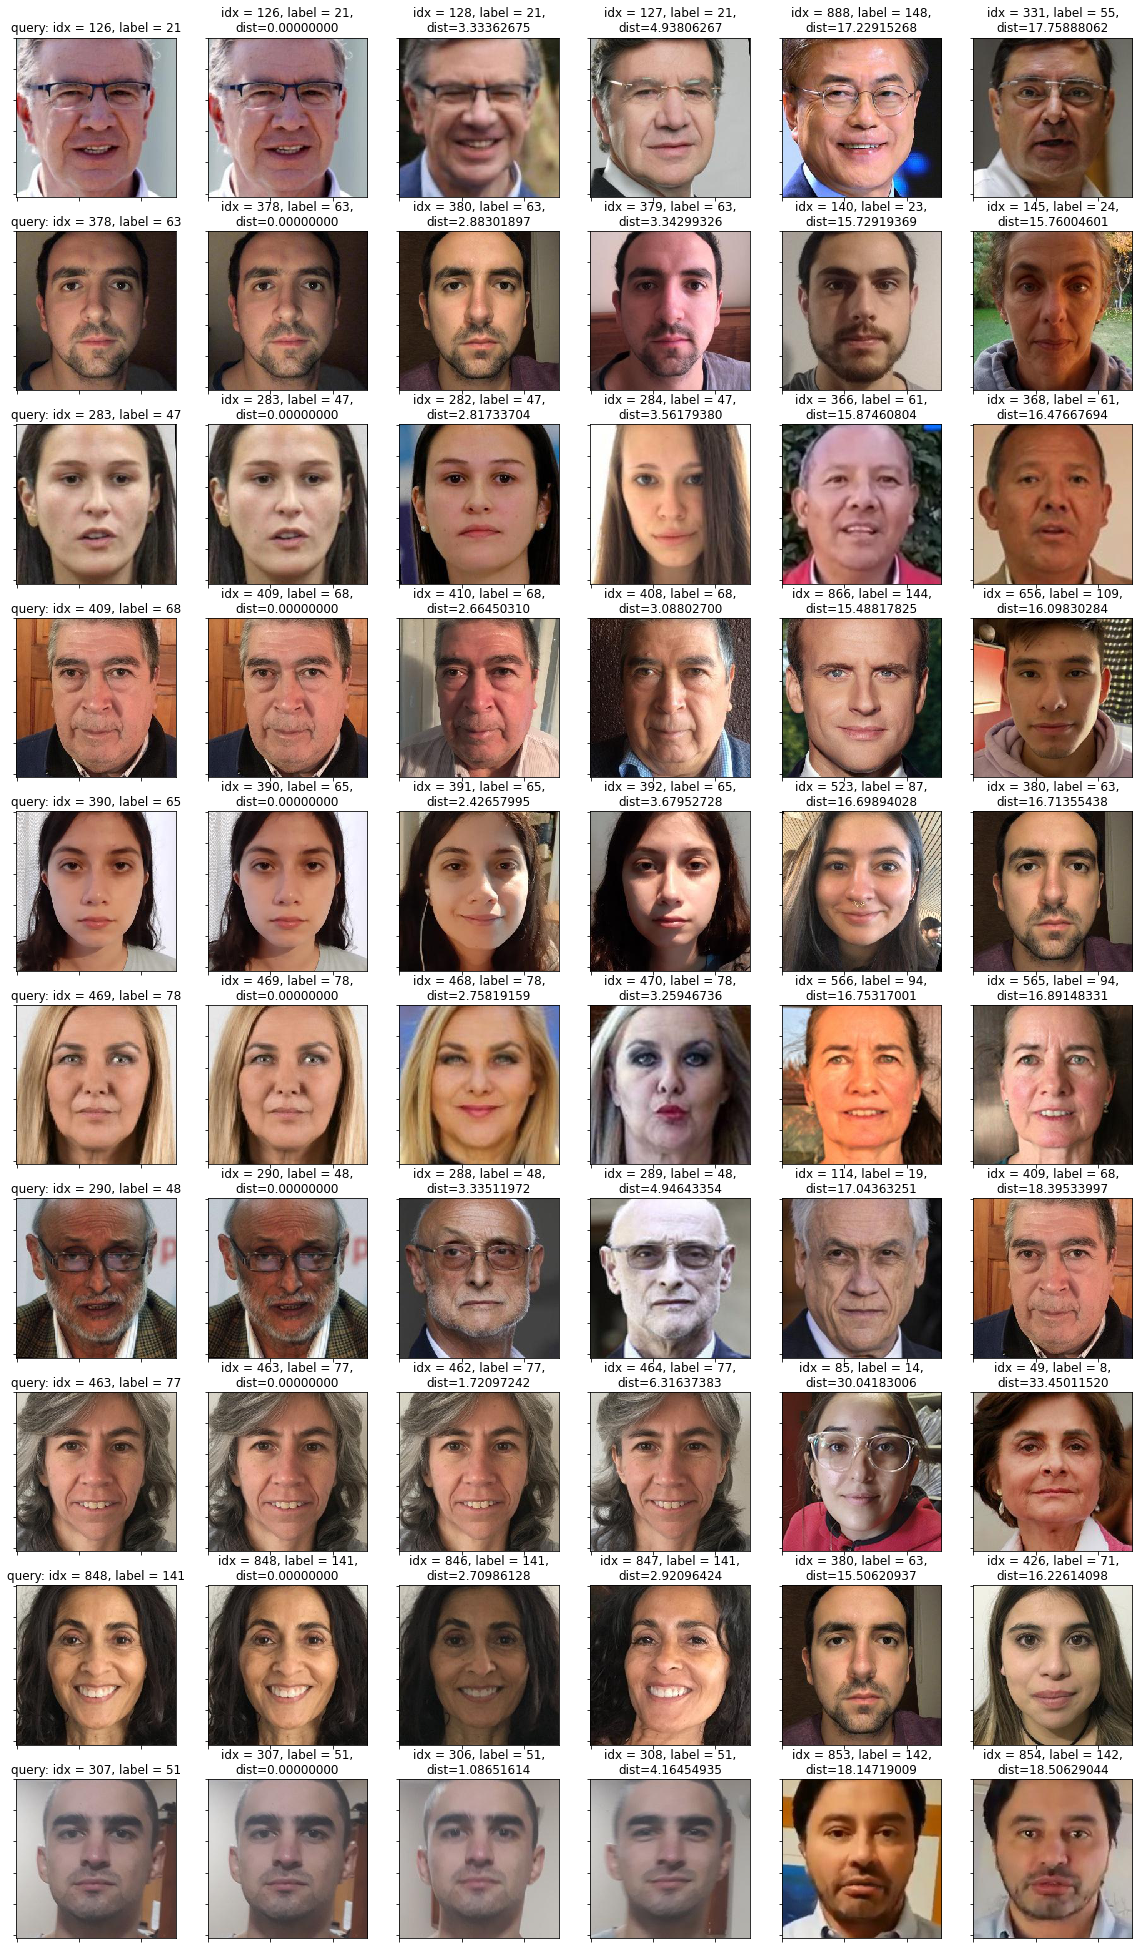

In [308]:
exp.visualize_rankings(exp.train_indexes, exp.train_labels, paths, mlp, 10, figsize=(20, 35))
# exp.visualize_rankings(exp.val_indexes, exp.val_labels, paths, mlp, 10, figsize=(20, 35))

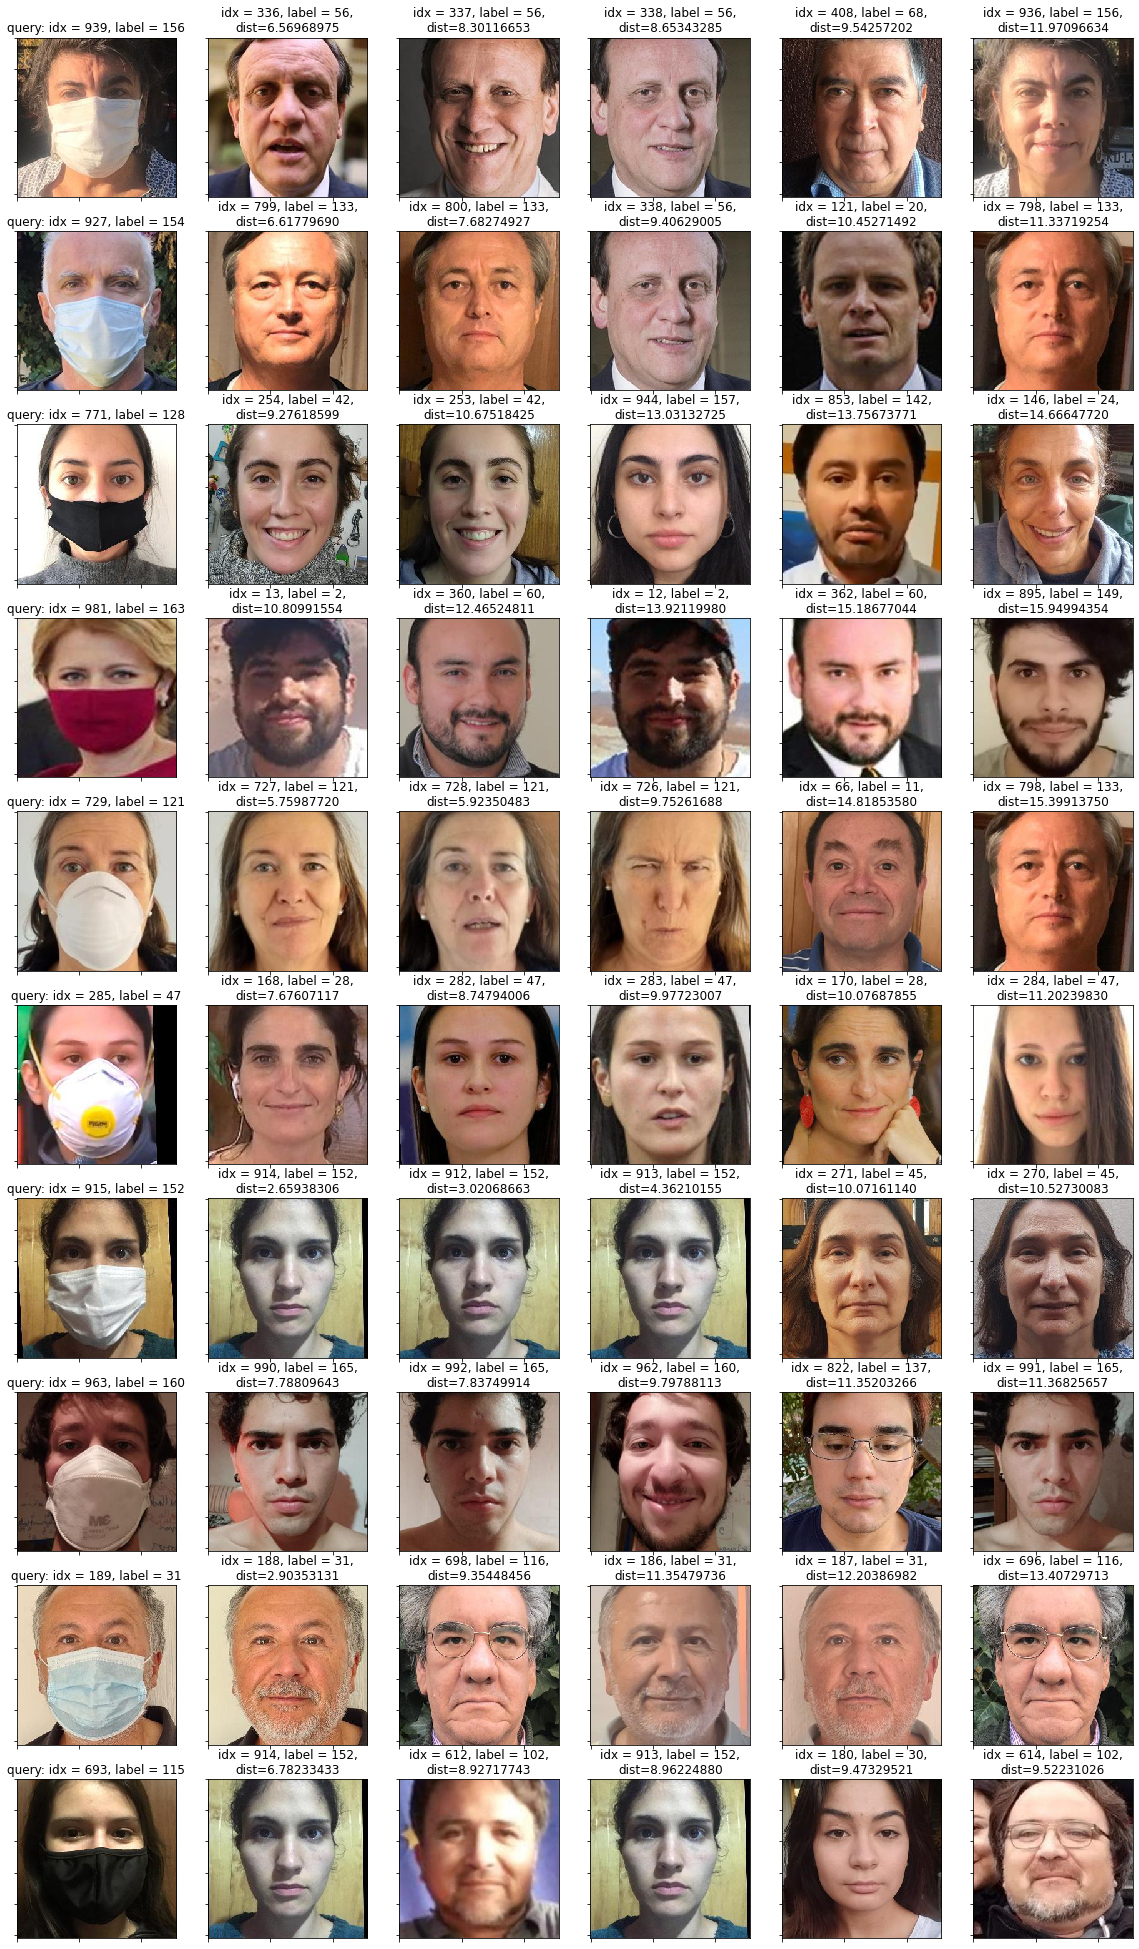

In [311]:
# exp.visualize_rankings(exp.train_indexes, exp.train_labels, paths, mlp, 10, figsize=(20, 35))
exp.visualize_rankings(exp.val_indexes, exp.val_labels, paths, mlp, 10, figsize=(20, 35))

In [328]:
exp.evaluate_mlp_validation(mlp, 6)

0.5783132530120482

In [310]:
exp.evaluate_mlp_validation(mlp, 1)

0.4397590361445783